<a href="https://colab.research.google.com/github/reshalfahsi/medical-image-generation/blob/master/Medical_Image_Generation_Using_Diffusion_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Medical Image Generation Using Diffusion Model**

## **Important Libraries**

In [1]:
!pip install -q --no-cache-dir lightning torchmetrics medmnist torch-fidelity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 166.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 143.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 82.1 MB/s eta 0:00:00


In [2]:
import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

from torchmetrics.image.fid import FrechetInceptionDistance

from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, Resize

from PIL import Image
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt

from medmnist.dataset import MedMNIST
from medmnist.info import INFO
from medmnist.utils import montage2d

import os
import cv2
import random
import math

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Configuration**

In [3]:
MAX_EPOCH = 30
DIFFUSION_STEP = 1000
BATCH_SIZE = 20
LR = 3e-4
CHECKPOINT_DIR = os.getcwd()
FLAG = "bloodmnist"
IMAGE_SIZE = 48
SCALE_DOWN = 2
N_CHANNEL = INFO[FLAG]['n_channels']
BETA_START = 1e-4
BETA_END = 2e-2

## **Dataset**

### **Configuration**

In [4]:
DATA_SEED = int(np.random.randint(2147483647))
print(f"Random seed: {DATA_SEED}")

Random seed: 1876798400


### **Utils**

In [5]:
image_transform = Compose(
    [
        Resize(IMAGE_SIZE),
        ToTensor(),
        Lambda(lambda x: (x * 2) - 1),
    ]
)

In [6]:
class MedMNIST2D(MedMNIST):
    def __getitem__(self, index):
        """
        return: (without transform/target_transofrm)
            img: PIL.Image
        """

        if self.split in ["test", "val"]:
            index = random.randint(0, len(self.imgs) - 1)

        img = self.imgs[index]
        img = Image.fromarray(img)

        if self.as_rgb:
            img = img.convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        return img

    def cut(self):
        CUT_INDEX = len(self.imgs) // 100 * 100
        self.imgs = self.imgs[:CUT_INDEX]
        self.info["n_samples"][self.split] = len(self.imgs)

    def __len__(self):
        if self.split in ["test", "val"]:
            self.info["n_samples"][self.split] = 4
            return 4
        return len(self.imgs)

    def montage(self, length=20, replace=False, save_folder=None):
        n_sel = length * length
        sel = np.random.choice(self.__len__(), size=n_sel, replace=replace)

        montage_img = montage2d(
            imgs=self.imgs, n_channels=self.info["n_channels"], sel=sel
        )

        if save_folder is not None:
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            montage_img.save(
                os.path.join(save_folder, f"{self.flag}_{self.split}_montage.jpg")
            )

        return montage_img


class BiomedicalDataset(MedMNIST2D):
    flag = FLAG

In [7]:
TrainDataset = BiomedicalDataset(
    split="train",
    transform=image_transform,
    download=True,
)
TestDataset = BiomedicalDataset(
    split="test",
    transform=image_transform,
    download=True,
)
ValDataset = BiomedicalDataset(
    split="val",
    transform=image_transform,
)

100%|██████████| 35.5M/35.5M [00:03<00:00, 9.24MB/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


In [8]:
TrainDataset.cut()
TestDataset.cut()
ValDataset.cut()

In [9]:
print(len(TrainDataset))
print(len(TestDataset))
print(len(ValDataset))

11900
4
4


### **Description**

In [10]:
INFO[FLAG]['description']

'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.'

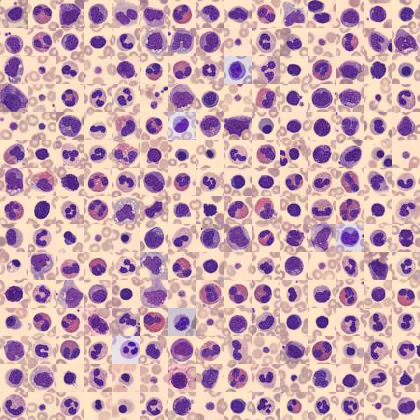

In [11]:
TrainDataset.montage(15)

## **Model**

### **Utils**

In [12]:
class AvgMeter(object):
    def __init__(self, num=40):
        self.num = num
        self.reset()

    def reset(self):
        self.scores = []

    def update(self, val):
        self.scores.append(val)

    def show(self):
        out = torch.mean(
            torch.stack(
                self.scores[np.maximum(len(self.scores)-self.num, 0):]
            )
        )
        return out

### **Noise Scheduler**

In [13]:
class NoiseScheduler(nn.Module):
    def __init__(
        self,
        T=DIFFUSION_STEP,
        beta_start=BETA_START,
        beta_end=BETA_END,
    ):
        super().__init__()

        self.T = T
        self.beta = torch.linspace(beta_start, beta_end, T).to(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def forward(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(
            1 - self.alpha_hat[t]
        ).unsqueeze(1).unsqueeze(1).unsqueeze(1)

        noise = torch.randn_like(x)
        x_noisy = sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * noise

        return x_noisy, noise

In [14]:
FORWARD = NoiseScheduler

### **U-Net**

In [15]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(
            -1, self.channels, self.size, self.size,
        )

In [16]:
class DoubleConv(nn.Module):
    def __init__(
        self, in_channels, out_channels, mid_channels=None, residual=False,
    ):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(
                in_channels, mid_channels, kernel_size=3, padding=1, bias=False,
            ),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(
                mid_channels, out_channels, kernel_size=3, padding=1, bias=False,
            ),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

In [17]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim):
        super().__init__()

        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(
            1, 1, x.shape[-2], x.shape[-1],
        )
        return x + emb

In [18]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim):
        super().__init__()

        self.up = nn.Upsample(
            scale_factor=2,
            mode="bilinear",
            align_corners=True,
        )
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(
            1, 1, x.shape[-2], x.shape[-1],
        )
        return x + emb

In [19]:
class PositionalEmbedding(nn.Module):
    def __init__(
        self,
        channels,
        device="cuda" if torch.cuda.is_available() else "cpu",
    ):
        super().__init__()
        self.channels = channels
        self.device = device

    def forward(self, time):
        inv_freq = 1.0 / (
            10000
            ** (
                torch.arange(0, self.channels, 2, device=self.device).float()
                / self.channels
            )
        )
        pos_enc_a = torch.sin(time.repeat(1, self.channels // 2) * inv_freq)
        pos_enc_b = torch.cos(time.repeat(1, self.channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

In [20]:
class UNet(nn.Module):
    def __init__(
        self,
        c_in=3,
        c_out=3,
        time_dim=256 // SCALE_DOWN,
        device="cuda" if torch.cuda.is_available() else "cpu",
    ):
        super().__init__()

        self.input_conv = DoubleConv(c_in, 64 // SCALE_DOWN)
        self.down1 = Down(64 // SCALE_DOWN, 128 // SCALE_DOWN, time_dim)
        self.sa1 = SelfAttention(128 // SCALE_DOWN, IMAGE_SIZE // 2)
        self.down2 = Down(128 // SCALE_DOWN, 256 // SCALE_DOWN, time_dim)
        self.sa2 = SelfAttention(256 // SCALE_DOWN, IMAGE_SIZE // 4)
        self.down3 = Down(256 // SCALE_DOWN, 256 // SCALE_DOWN, time_dim)
        self.sa3 = SelfAttention(256 // SCALE_DOWN, IMAGE_SIZE // 8)

        self.bridge1 = DoubleConv(256 // SCALE_DOWN, 512 // SCALE_DOWN)
        self.bridge2 = DoubleConv(512 // SCALE_DOWN, 512 // SCALE_DOWN)
        self.bridge3 = DoubleConv(512 // SCALE_DOWN, 256 // SCALE_DOWN)

        self.up1 = Up(512 // SCALE_DOWN, 128 // SCALE_DOWN, time_dim)
        self.sa4 = SelfAttention(128 // SCALE_DOWN, IMAGE_SIZE // 4)
        self.up2 = Up(256 // SCALE_DOWN, 64 // SCALE_DOWN, time_dim)
        self.sa5 = SelfAttention(64 // SCALE_DOWN, IMAGE_SIZE // 2)
        self.up3 = Up(128 // SCALE_DOWN, 64 // SCALE_DOWN, time_dim)
        self.sa6 = SelfAttention(64 // SCALE_DOWN, IMAGE_SIZE)
        self.out_conv = nn.Conv2d(64 // SCALE_DOWN, c_out, kernel_size=1)

        self.pos_encoding = PositionalEmbedding(time_dim, device)

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t)

        x1 = self.input_conv(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bridge1(x4)
        x4 = self.bridge2(x4)
        x4 = self.bridge3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.out_conv(x)
        return output

In [21]:
BACKWARD = UNet

### **Wrapper**

In [22]:
class DiffusionModel(L.LightningModule):
    def __init__(
        self,
        forward_model,
        backward_model,
        batch_size,
        lr,
        max_epoch,
    ):
        super().__init__()

        self.forward_model = forward_model
        self.backward_model = backward_model

        self.batch_size = batch_size
        self.lr = lr
        self.max_epoch = max_epoch

        self.automatic_optimization = False

        self.model_loss = []
        self.val_fid = []

        self.model_loss_recorder = AvgMeter()
        self.val_fid_recorder = AvgMeter()

        self._device = "cuda" if torch.cuda.is_available() else "cpu"
        self._T = self.forward_model.T

        self.fid = FrechetInceptionDistance(
            feature=64,
            input_img_size=(3, IMAGE_SIZE, IMAGE_SIZE),
            normalize=True,
        )

    def forward(self, x=None, t=None):
        if self.training:
            x_noisy, noise = self.forward_model(x, t)
            noise_pred = self.backward_model(x_noisy, t)
            return F.l1_loss(noise, noise_pred)
        else:
            return self.sample(progress=True, verbose=True)

    def sample(self, n=1, progress=False, verbose=False, n_progress=5):
        self.backward_model.eval()

        progress_image = None if not progress else list()

        with torch.no_grad():
            x = torch.randn(
                (n, 3, IMAGE_SIZE, IMAGE_SIZE)
            ).to(self.device)

            if progress:
                progress_image.append(x.detach().cpu())

            if verbose:
                iteration = tqdm(reversed(range(0, self._T)), position=0)
            else:
                iteration = reversed(range(0, self._T))

            for i in iteration:
                t = (torch.ones(n) * i).long().to(self.device)

                noise_pred = self.backward_model(x, t)
                alpha = self.forward_model.alpha[t][:, None, None, None]
                alpha_hat = self.forward_model.alpha_hat[t][:, None, None, None]
                beta = self.forward_model.beta[t][:, None, None, None]

                if i:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)

                x = (
                    1 / torch.sqrt(alpha)
                    * (
                        x
                        - ((1 - alpha) / (torch.sqrt(1 - alpha_hat)))
                        * noise_pred
                      )
                    + torch.sqrt(beta)
                    * noise
                )
                x = torch.clamp(x, -1.0, 1.0)

                if i % (self._T // n_progress) == 0 and progress:
                    progress_image.append(x.detach().cpu())

        if progress:
            progress_image.pop(n_progress // 2)

            return progress_image

        return x

    def on_train_epoch_start(self):
        self.fid.reset()

    def training_step(self, batch, batch_nb):
        x = batch

        self.fid.update((x + 1.0) / 2.0, real=True)

        t = torch.randint(
            0,
            self._T,
            (self.batch_size,),
            device=self._device,
        ).long()

        loss = self(x, t)

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.log("model_loss", loss, prog_bar=True)
        self.model_loss_recorder.update(loss.data)

    def on_train_epoch_end(self):
        self.model_loss.append(
            self.model_loss_recorder.show().data.cpu().numpy(),
        )
        self.model_loss_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x = batch
        self.fid.update((x + 1.0) / 2.0, real=True)

        _x = self.sample(x.shape[0])
        self.fid.update((_x + 1.0) / 2.0, real=False)

        fid = self.fid.compute().data.cpu()
        self.log("val_fid", fid, prog_bar=True)
        self.val_fid_recorder.update(fid)

    def on_validation_epoch_end(self):
        self.val_fid.append(self.val_fid_recorder.show().data.cpu().numpy())
        self.val_fid_recorder = AvgMeter()

    def test_step(self, batch, batch_nb):
        x = batch
        self.fid.update((x + 1.0) / 2.0, real=True)

        _x = self.sample(x.shape[0])
        self.fid.update((_x + 1.0) / 2.0, real=False)

    def on_test_epoch_end(self):
        fid = self.fid.compute().data.cpu()
        self.log("test_fid", fid, prog_bar=False, logger=True)

    def on_train_end(self):
        # Loss
        loss_img_file = f"/content/{MODEL_NAME}_loss_plot.png"
        plt.plot(self.model_loss, color="r")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        # Evaluation Metrics
        evaluation_metric_img_file = f"/content/{MODEL_NAME}_fid_plot.png"
        plt.plot(self.val_fid[1:], color="b")
        plt.title("FID Curves")
        plt.xlabel("Epoch")
        plt.ylabel("FID")
        plt.grid()
        plt.savefig(evaluation_metric_img_file)
        plt.clf()
        img = cv2.imread(evaluation_metric_img_file)
        cv2_imshow(img)

    def train_dataloader(self):
        return data.DataLoader(
            dataset=TrainDataset,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=ValDataset,
            batch_size=2,
            shuffle=True,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=TestDataset,
            batch_size=2,
            shuffle=True,
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr)

        return [optimizer]

In [23]:
MODEL_NAME = DiffusionModel.__name__

## **Training**

In [24]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 1716704133


INFO: Seed set to 1716704133
INFO:lightning.fabric.utilities.seed:Seed set to 1716704133
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:01<00:00, 66.5MB/s]
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type                     | Params | Mode 
--------------------------------------------------------------------
0 | fo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


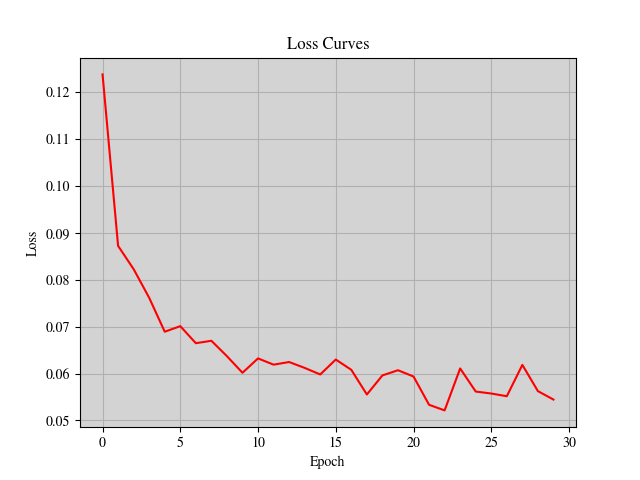

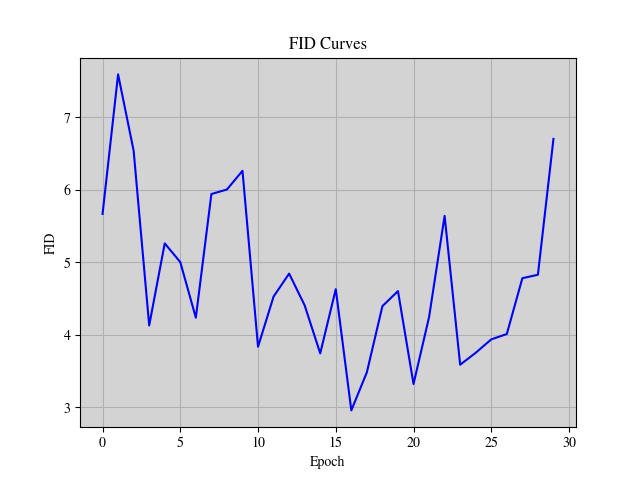

<Figure size 640x480 with 0 Axes>

In [25]:
seed_everything(SEED, workers=True)

model = DiffusionModel(FORWARD(), BACKWARD(), BATCH_SIZE, LR, MAX_EPOCH)

checkpoint = ModelCheckpoint(
    monitor='val_fid',
    dirpath=CHECKPOINT_DIR,
    mode='min',
)

trainer = Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=MAX_EPOCH,
    callbacks=[checkpoint],
    log_every_n_steps=5,
)
trainer.fit(model)

## **Testing**

In [26]:
os.rename(
    checkpoint.best_model_path,
    os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt")
)

In [27]:
trainer.test(ckpt_path=os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt"))

INFO: Restoring states from the checkpoint path at /content/DiffusionModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/DiffusionModel_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/DiffusionModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/DiffusionModel_best.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_fid          │     4.071456432342529     │
└───────────────────────────┴───────────────────────────┘

[{'test_fid': 4.071456432342529}]

## **Inference**

### **Utils**

In [33]:
def show_tensor_image(image):
    reverse_transforms = Compose([
        Lambda(lambda t: (t + 1) / 2),
        Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        Lambda(lambda t: t * 255.),
        Lambda(lambda t: t.numpy().astype(np.uint8)),
        ToPILImage(),
        Resize(IMAGE_SIZE),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]

    plt.axis('off')
    plt.imshow(reverse_transforms(image))

In [34]:
CHECKPOINT_INFERENCE = os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt")

In [35]:
N_SAMPLE = 5

In [36]:
model = DiffusionModel.load_from_checkpoint(
    checkpoint_path=CHECKPOINT_INFERENCE,
    map_location="cuda" if torch.cuda.is_available() else "cpu",
    forward_model=FORWARD(),
    backward_model=BACKWARD(),
    batch_size=BATCH_SIZE,
    lr=LR,
    max_epoch=MAX_EPOCH,
)
model.eval()

DiffusionModel(
  (forward_model): NoiseScheduler()
  (backward_model): UNet(
    (input_conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): GroupNorm(1, 32, eps=1e-05, affine=True)
        (2): GELU(approximate='none')
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): GroupNorm(1, 32, eps=1e-05, affine=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): GroupNorm(1, 32, eps=1e-05, affine=True)
            (2): GELU(approximate='none')
            (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (4): GroupNor

### **Visualize**

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

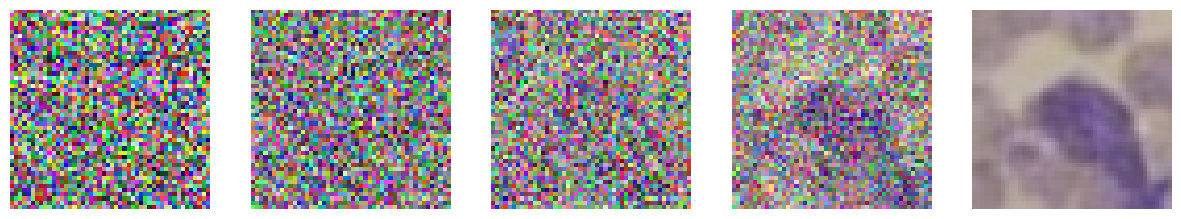

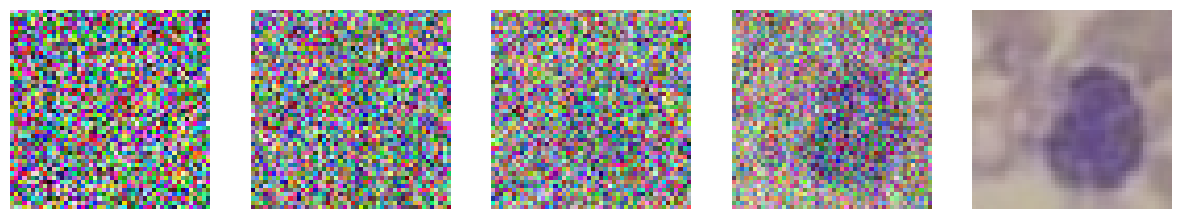

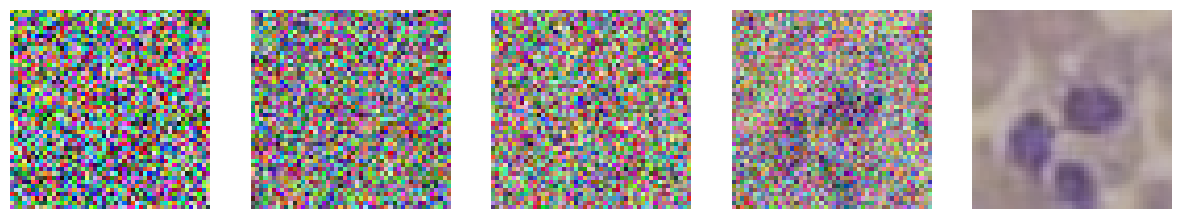

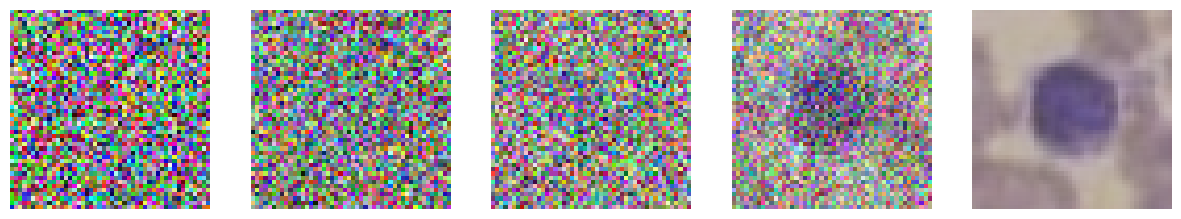

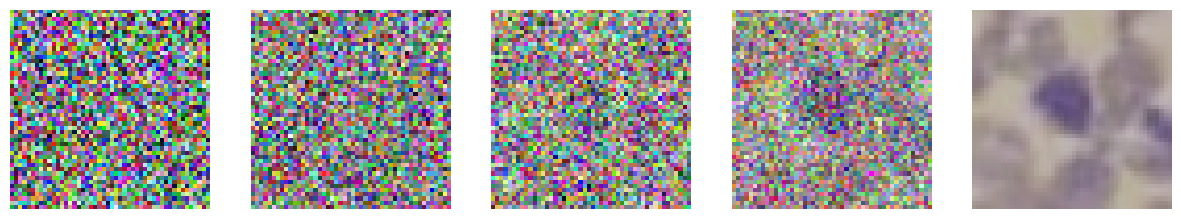

In [37]:
for sample in range(N_SAMPLE):
    plt.figure(figsize=(15, 15))
    progress_image = model()
    for index, image in enumerate(progress_image):
        plt.subplot(5, 5, (sample * N_SAMPLE) + (index + 1))
        show_tensor_image(image)